# Week6 Homework

In [1]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

/home/rodrigo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/rodrigo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rodrigo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rodrigo/anaconda3/lib/python3.6/site-p

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
dataSet = input_data.read_data_sets('./data/fashion', one_hot=True, reshape=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/fashion/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/fashion/t10k-images-idx3-ubyte.gz
Extracting ./data/fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# d1 = fashion_mnist.load_data()

# (X_train, y_train), (X_test, y_test) = d1

# print(len(d1[0]), len(d1[1]))
# print(X_train.shape)
# # print(y_train.shape)

# X_train = X_train / 127.5 - 1.
# X_train = np.expand_dims(X_train, axis=3)
# print(X_train.shape)

In [4]:
# # d2 = dataSet.train.next_batch(128)

# X_train = dataSet.train.images
# y_train = dataSet.train.labels

# X_test = dataSet.test.images
# y_test = dataSet.test.labels

# print(X_train.shape)
# # print(y_train.shape)


# X_train = X_train / 127.5 - 1.
# X_train = np.expand_dims(X_train, axis=3)

# print(X_train.shape)

In [5]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        data = dataSet.train.next_batch(batch_size)

        # Load the dataset
#         (X_train, _), (_, _) = fashion_mnist.load_data()

        X_train = dataSet.train.images
        y_train = dataSet.train.labels

        X_test = dataSet.test.images
        y_test = dataSet.test.labels

#         https://keras.io/datasets/
#         (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
        # Rescale -1 to 1
#         X_train = X_train / 127.5 - 1.
#         X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 

/home/rodrigo/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.584724, acc.: 79.69%] [G loss: 0.637935]


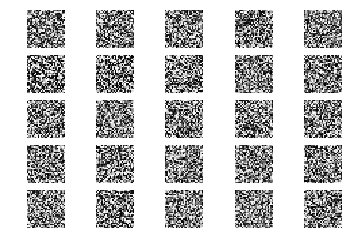

1 [D loss: 0.548326, acc.: 64.06%] [G loss: 0.664069]
2 [D loss: 0.474032, acc.: 76.56%] [G loss: 0.834705]
3 [D loss: 0.355407, acc.: 87.50%] [G loss: 0.951265]
4 [D loss: 0.321697, acc.: 89.06%] [G loss: 1.125364]
5 [D loss: 0.278561, acc.: 90.62%] [G loss: 1.215946]
6 [D loss: 0.247593, acc.: 100.00%] [G loss: 1.426753]
7 [D loss: 0.212220, acc.: 100.00%] [G loss: 1.663891]
8 [D loss: 0.153180, acc.: 100.00%] [G loss: 1.681065]
9 [D loss: 0.143743, acc.: 100.00%] [G loss: 1.777042]
10 [D loss: 0.139686, acc.: 100.00%] [G loss: 1.926661]
11 [D loss: 0.149273, acc.: 100.00%] [G loss: 1.978689]
12 [D loss: 0.131255, acc.: 100.00%] [G loss: 2.098743]
13 [D loss: 0.138186, acc.: 100.00%] [G loss: 2.155978]
14 [D loss: 0.092330, acc.: 100.00%] [G loss: 2.199167]
15 [D loss: 0.099250, acc.: 100.00%] [G loss: 2.188837]
16 [D loss: 0.083275, acc.: 100.00%] [G loss: 2.362693]
17 [D loss: 0.099138, acc.: 100.00%] [G loss: 2.426936]
18 [D loss: 0.069435, acc.: 100.00%] [G loss: 2.441649]
19 [D 

149 [D loss: 0.297547, acc.: 85.94%] [G loss: 3.166415]
150 [D loss: 0.227163, acc.: 90.62%] [G loss: 3.824464]
151 [D loss: 0.260986, acc.: 89.06%] [G loss: 3.862313]
152 [D loss: 0.256162, acc.: 92.19%] [G loss: 4.177978]
153 [D loss: 0.164997, acc.: 95.31%] [G loss: 3.683472]
154 [D loss: 0.349480, acc.: 84.38%] [G loss: 4.492132]
155 [D loss: 0.510472, acc.: 79.69%] [G loss: 3.851202]
156 [D loss: 0.249358, acc.: 90.62%] [G loss: 3.822917]
157 [D loss: 0.369079, acc.: 82.81%] [G loss: 4.403283]
158 [D loss: 0.526510, acc.: 76.56%] [G loss: 4.137515]
159 [D loss: 0.261337, acc.: 89.06%] [G loss: 3.651345]
160 [D loss: 0.324144, acc.: 82.81%] [G loss: 3.432112]
161 [D loss: 0.295721, acc.: 82.81%] [G loss: 3.972308]
162 [D loss: 0.227404, acc.: 90.62%] [G loss: 3.838999]
163 [D loss: 0.339589, acc.: 85.94%] [G loss: 4.484551]
164 [D loss: 0.955705, acc.: 51.56%] [G loss: 3.120295]
165 [D loss: 0.199954, acc.: 93.75%] [G loss: 4.026234]
166 [D loss: 0.277018, acc.: 84.38%] [G loss: 3.

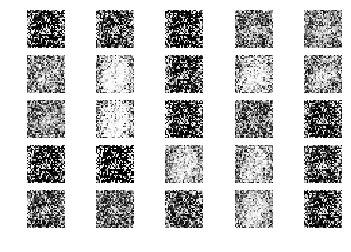

201 [D loss: 0.176594, acc.: 93.75%] [G loss: 4.117468]
202 [D loss: 0.226576, acc.: 93.75%] [G loss: 4.006367]
203 [D loss: 0.248064, acc.: 87.50%] [G loss: 3.898248]
204 [D loss: 0.242716, acc.: 90.62%] [G loss: 4.465949]
205 [D loss: 0.228784, acc.: 92.19%] [G loss: 4.225909]
206 [D loss: 0.129572, acc.: 100.00%] [G loss: 3.951857]
207 [D loss: 0.232763, acc.: 92.19%] [G loss: 4.828290]
208 [D loss: 0.229419, acc.: 92.19%] [G loss: 4.105995]
209 [D loss: 0.133465, acc.: 96.88%] [G loss: 3.807565]
210 [D loss: 0.256342, acc.: 89.06%] [G loss: 3.836479]
211 [D loss: 0.278591, acc.: 89.06%] [G loss: 4.536509]
212 [D loss: 0.195008, acc.: 92.19%] [G loss: 3.809186]
213 [D loss: 0.185445, acc.: 93.75%] [G loss: 3.754060]
214 [D loss: 0.177587, acc.: 93.75%] [G loss: 3.955823]
215 [D loss: 0.157564, acc.: 96.88%] [G loss: 3.672424]
216 [D loss: 0.260660, acc.: 87.50%] [G loss: 4.542005]
217 [D loss: 0.193420, acc.: 96.88%] [G loss: 4.957707]
218 [D loss: 0.150342, acc.: 93.75%] [G loss: 4

350 [D loss: 0.473257, acc.: 78.12%] [G loss: 4.102310]
351 [D loss: 0.555766, acc.: 71.88%] [G loss: 3.331106]
352 [D loss: 0.538247, acc.: 75.00%] [G loss: 3.849175]
353 [D loss: 0.388331, acc.: 84.38%] [G loss: 4.048640]
354 [D loss: 0.459827, acc.: 75.00%] [G loss: 4.162255]
355 [D loss: 0.380215, acc.: 81.25%] [G loss: 3.296959]
356 [D loss: 0.485610, acc.: 76.56%] [G loss: 3.800355]
357 [D loss: 0.473866, acc.: 78.12%] [G loss: 4.436972]
358 [D loss: 0.446028, acc.: 76.56%] [G loss: 3.168672]
359 [D loss: 0.542267, acc.: 75.00%] [G loss: 4.160767]
360 [D loss: 0.446310, acc.: 84.38%] [G loss: 4.111316]
361 [D loss: 0.658942, acc.: 59.38%] [G loss: 3.339796]
362 [D loss: 0.457421, acc.: 78.12%] [G loss: 3.436062]
363 [D loss: 0.417024, acc.: 79.69%] [G loss: 3.453910]
364 [D loss: 0.366767, acc.: 81.25%] [G loss: 3.675583]
365 [D loss: 0.509659, acc.: 76.56%] [G loss: 4.192503]
366 [D loss: 0.470949, acc.: 75.00%] [G loss: 3.206523]
367 [D loss: 0.555131, acc.: 73.44%] [G loss: 4.

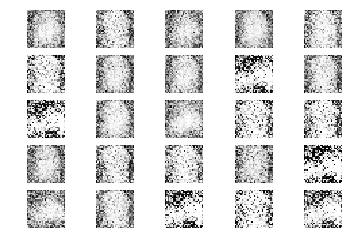

401 [D loss: 0.529763, acc.: 70.31%] [G loss: 3.134876]
402 [D loss: 0.529040, acc.: 71.88%] [G loss: 2.476108]
403 [D loss: 0.511293, acc.: 79.69%] [G loss: 3.301555]
404 [D loss: 0.430025, acc.: 76.56%] [G loss: 3.836744]
405 [D loss: 0.467162, acc.: 84.38%] [G loss: 2.875641]
406 [D loss: 0.516285, acc.: 68.75%] [G loss: 3.415778]
407 [D loss: 0.565347, acc.: 67.19%] [G loss: 2.870233]
408 [D loss: 0.588865, acc.: 65.62%] [G loss: 3.404468]
409 [D loss: 0.528101, acc.: 70.31%] [G loss: 3.155772]
410 [D loss: 0.474342, acc.: 76.56%] [G loss: 2.930025]
411 [D loss: 0.388683, acc.: 87.50%] [G loss: 3.221921]
412 [D loss: 0.594795, acc.: 67.19%] [G loss: 3.317600]
413 [D loss: 0.529607, acc.: 70.31%] [G loss: 2.884231]
414 [D loss: 0.486578, acc.: 70.31%] [G loss: 2.609375]
415 [D loss: 0.442199, acc.: 76.56%] [G loss: 3.581957]
416 [D loss: 0.456101, acc.: 81.25%] [G loss: 3.361587]
417 [D loss: 0.618130, acc.: 75.00%] [G loss: 3.341557]
418 [D loss: 0.457235, acc.: 78.12%] [G loss: 3.

551 [D loss: 0.641588, acc.: 67.19%] [G loss: 1.880774]
552 [D loss: 0.625201, acc.: 67.19%] [G loss: 1.460875]
553 [D loss: 0.575178, acc.: 73.44%] [G loss: 1.557777]
554 [D loss: 0.609262, acc.: 70.31%] [G loss: 1.730530]
555 [D loss: 0.457260, acc.: 76.56%] [G loss: 2.088274]
556 [D loss: 0.592272, acc.: 75.00%] [G loss: 1.805622]
557 [D loss: 0.647466, acc.: 57.81%] [G loss: 1.611445]
558 [D loss: 0.500894, acc.: 81.25%] [G loss: 1.958382]
559 [D loss: 0.661946, acc.: 67.19%] [G loss: 1.732551]
560 [D loss: 0.644112, acc.: 67.19%] [G loss: 1.616587]
561 [D loss: 0.657260, acc.: 59.38%] [G loss: 1.816772]
562 [D loss: 0.524179, acc.: 70.31%] [G loss: 1.728944]
563 [D loss: 0.723200, acc.: 60.94%] [G loss: 1.654899]
564 [D loss: 0.706308, acc.: 59.38%] [G loss: 1.590404]
565 [D loss: 0.521337, acc.: 78.12%] [G loss: 1.806744]
566 [D loss: 0.590822, acc.: 65.62%] [G loss: 1.652992]
567 [D loss: 0.639501, acc.: 64.06%] [G loss: 1.674341]
568 [D loss: 0.536858, acc.: 68.75%] [G loss: 1.

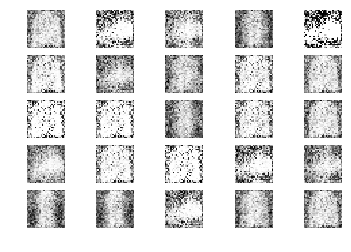

601 [D loss: 0.671412, acc.: 64.06%] [G loss: 1.625258]
602 [D loss: 0.506793, acc.: 78.12%] [G loss: 2.006429]
603 [D loss: 0.632870, acc.: 68.75%] [G loss: 1.720110]
604 [D loss: 0.602537, acc.: 75.00%] [G loss: 1.641840]
605 [D loss: 0.583323, acc.: 70.31%] [G loss: 1.927241]
606 [D loss: 0.538113, acc.: 79.69%] [G loss: 1.695132]
607 [D loss: 0.575668, acc.: 71.88%] [G loss: 1.529849]
608 [D loss: 0.614972, acc.: 68.75%] [G loss: 1.355123]
609 [D loss: 0.617077, acc.: 65.62%] [G loss: 1.473701]
610 [D loss: 0.735465, acc.: 51.56%] [G loss: 1.488861]
611 [D loss: 0.606218, acc.: 70.31%] [G loss: 1.460794]
612 [D loss: 0.605846, acc.: 70.31%] [G loss: 1.514431]
613 [D loss: 0.524120, acc.: 78.12%] [G loss: 1.507443]
614 [D loss: 0.671661, acc.: 67.19%] [G loss: 1.542742]
615 [D loss: 0.568972, acc.: 79.69%] [G loss: 1.610128]
616 [D loss: 0.754075, acc.: 53.12%] [G loss: 1.224533]
617 [D loss: 0.680298, acc.: 62.50%] [G loss: 1.792137]
618 [D loss: 0.570661, acc.: 70.31%] [G loss: 1.

748 [D loss: 0.658109, acc.: 60.94%] [G loss: 1.466528]
749 [D loss: 0.515991, acc.: 78.12%] [G loss: 1.589546]
750 [D loss: 0.682222, acc.: 65.62%] [G loss: 1.466781]
751 [D loss: 0.637847, acc.: 62.50%] [G loss: 1.320538]
752 [D loss: 0.628248, acc.: 64.06%] [G loss: 1.259690]
753 [D loss: 0.517441, acc.: 82.81%] [G loss: 1.417051]
754 [D loss: 0.667631, acc.: 70.31%] [G loss: 1.311229]
755 [D loss: 0.585872, acc.: 73.44%] [G loss: 1.400192]
756 [D loss: 0.601122, acc.: 70.31%] [G loss: 1.440760]
757 [D loss: 0.723113, acc.: 62.50%] [G loss: 1.267869]
758 [D loss: 0.715963, acc.: 51.56%] [G loss: 1.198162]
759 [D loss: 0.662191, acc.: 59.38%] [G loss: 1.338332]
760 [D loss: 0.627688, acc.: 65.62%] [G loss: 1.270812]
761 [D loss: 0.650884, acc.: 62.50%] [G loss: 1.267316]
762 [D loss: 0.693957, acc.: 59.38%] [G loss: 1.287504]
763 [D loss: 0.663276, acc.: 62.50%] [G loss: 1.251416]
764 [D loss: 0.605266, acc.: 70.31%] [G loss: 1.276668]
765 [D loss: 0.503534, acc.: 78.12%] [G loss: 1.

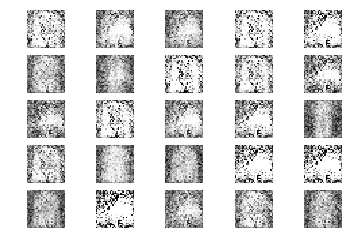

801 [D loss: 0.638729, acc.: 62.50%] [G loss: 1.180070]
802 [D loss: 0.512287, acc.: 82.81%] [G loss: 1.306493]
803 [D loss: 0.589029, acc.: 70.31%] [G loss: 1.334850]
804 [D loss: 0.446105, acc.: 87.50%] [G loss: 1.584435]
805 [D loss: 0.616403, acc.: 75.00%] [G loss: 1.275497]
806 [D loss: 0.678095, acc.: 64.06%] [G loss: 1.206504]
807 [D loss: 0.681639, acc.: 53.12%] [G loss: 1.058440]
808 [D loss: 0.600542, acc.: 71.88%] [G loss: 1.156838]
809 [D loss: 0.758334, acc.: 40.62%] [G loss: 1.142773]
810 [D loss: 0.613130, acc.: 70.31%] [G loss: 1.209719]
811 [D loss: 0.576354, acc.: 79.69%] [G loss: 1.394882]
812 [D loss: 0.748844, acc.: 54.69%] [G loss: 1.132305]
813 [D loss: 0.665817, acc.: 57.81%] [G loss: 1.010619]
814 [D loss: 0.600132, acc.: 64.06%] [G loss: 1.125300]
815 [D loss: 0.554231, acc.: 73.44%] [G loss: 1.359986]
816 [D loss: 0.564287, acc.: 76.56%] [G loss: 1.442470]
817 [D loss: 0.518862, acc.: 75.00%] [G loss: 1.522481]
818 [D loss: 0.724431, acc.: 60.94%] [G loss: 1.

950 [D loss: 0.695572, acc.: 54.69%] [G loss: 1.101816]
951 [D loss: 0.672746, acc.: 57.81%] [G loss: 1.025283]
952 [D loss: 0.705173, acc.: 53.12%] [G loss: 0.938463]
953 [D loss: 0.600978, acc.: 76.56%] [G loss: 1.067800]
954 [D loss: 0.752802, acc.: 51.56%] [G loss: 0.926238]
955 [D loss: 0.636757, acc.: 60.94%] [G loss: 1.009920]
956 [D loss: 0.658469, acc.: 65.62%] [G loss: 1.107841]
957 [D loss: 0.674166, acc.: 62.50%] [G loss: 0.993363]
958 [D loss: 0.751153, acc.: 51.56%] [G loss: 0.854986]
959 [D loss: 0.585733, acc.: 70.31%] [G loss: 0.955385]
960 [D loss: 0.717079, acc.: 53.12%] [G loss: 0.991064]
961 [D loss: 0.670234, acc.: 56.25%] [G loss: 0.907791]
962 [D loss: 0.660231, acc.: 56.25%] [G loss: 0.899721]
963 [D loss: 0.685253, acc.: 56.25%] [G loss: 0.899035]
964 [D loss: 0.696476, acc.: 53.12%] [G loss: 0.901654]
965 [D loss: 0.787441, acc.: 39.06%] [G loss: 0.898882]
966 [D loss: 0.627720, acc.: 64.06%] [G loss: 0.947118]
967 [D loss: 0.716308, acc.: 54.69%] [G loss: 0.

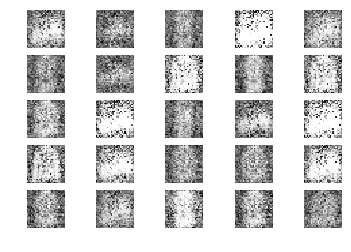

1001 [D loss: 0.705225, acc.: 59.38%] [G loss: 0.899720]
1002 [D loss: 0.637457, acc.: 59.38%] [G loss: 0.981914]
1003 [D loss: 0.675261, acc.: 60.94%] [G loss: 0.939974]
1004 [D loss: 0.640526, acc.: 62.50%] [G loss: 0.972343]
1005 [D loss: 0.628339, acc.: 70.31%] [G loss: 1.177327]
1006 [D loss: 0.582533, acc.: 65.62%] [G loss: 1.093044]
1007 [D loss: 0.600756, acc.: 68.75%] [G loss: 1.065193]
1008 [D loss: 0.633924, acc.: 65.62%] [G loss: 1.011816]
1009 [D loss: 0.676041, acc.: 59.38%] [G loss: 0.903347]
1010 [D loss: 0.625780, acc.: 57.81%] [G loss: 1.021001]
1011 [D loss: 0.674064, acc.: 53.12%] [G loss: 0.903966]
1012 [D loss: 0.801204, acc.: 50.00%] [G loss: 0.872839]
1013 [D loss: 0.627735, acc.: 60.94%] [G loss: 0.887739]
1014 [D loss: 0.614727, acc.: 70.31%] [G loss: 0.955863]
1015 [D loss: 0.598362, acc.: 73.44%] [G loss: 0.997616]
1016 [D loss: 0.629854, acc.: 68.75%] [G loss: 0.958810]
1017 [D loss: 0.687623, acc.: 59.38%] [G loss: 0.985710]
1018 [D loss: 0.772061, acc.: 4

1145 [D loss: 0.641502, acc.: 64.06%] [G loss: 0.849025]
1146 [D loss: 0.660398, acc.: 59.38%] [G loss: 0.840280]
1147 [D loss: 0.653952, acc.: 64.06%] [G loss: 0.823350]
1148 [D loss: 0.581900, acc.: 73.44%] [G loss: 0.858587]
1149 [D loss: 0.667552, acc.: 60.94%] [G loss: 0.906813]
1150 [D loss: 0.734343, acc.: 46.88%] [G loss: 0.942820]
1151 [D loss: 0.650859, acc.: 64.06%] [G loss: 0.962802]
1152 [D loss: 0.682110, acc.: 50.00%] [G loss: 0.803934]
1153 [D loss: 0.632005, acc.: 64.06%] [G loss: 0.823381]
1154 [D loss: 0.624194, acc.: 60.94%] [G loss: 0.880584]
1155 [D loss: 0.672946, acc.: 54.69%] [G loss: 0.916922]
1156 [D loss: 0.713293, acc.: 56.25%] [G loss: 0.851241]
1157 [D loss: 0.641343, acc.: 64.06%] [G loss: 0.825062]
1158 [D loss: 0.726573, acc.: 46.88%] [G loss: 0.801150]
1159 [D loss: 0.664207, acc.: 56.25%] [G loss: 0.818342]
1160 [D loss: 0.730475, acc.: 48.44%] [G loss: 0.798086]
1161 [D loss: 0.726881, acc.: 51.56%] [G loss: 0.791622]
1162 [D loss: 0.643201, acc.: 6

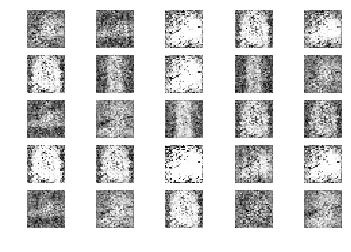

1201 [D loss: 0.713620, acc.: 57.81%] [G loss: 0.777676]
1202 [D loss: 0.700000, acc.: 53.12%] [G loss: 0.815874]
1203 [D loss: 0.663007, acc.: 68.75%] [G loss: 0.809720]
1204 [D loss: 0.691599, acc.: 59.38%] [G loss: 0.818678]
1205 [D loss: 0.710199, acc.: 56.25%] [G loss: 0.822829]
1206 [D loss: 0.679263, acc.: 59.38%] [G loss: 0.843232]
1207 [D loss: 0.736813, acc.: 56.25%] [G loss: 0.805167]
1208 [D loss: 0.693934, acc.: 59.38%] [G loss: 0.823323]
1209 [D loss: 0.675972, acc.: 57.81%] [G loss: 0.790222]
1210 [D loss: 0.631349, acc.: 67.19%] [G loss: 0.867452]
1211 [D loss: 0.687815, acc.: 53.12%] [G loss: 0.886556]
1212 [D loss: 0.677501, acc.: 57.81%] [G loss: 0.834009]
1213 [D loss: 0.666445, acc.: 57.81%] [G loss: 0.806263]
1214 [D loss: 0.694704, acc.: 45.31%] [G loss: 0.821248]
1215 [D loss: 0.676825, acc.: 53.12%] [G loss: 0.796883]
1216 [D loss: 0.638801, acc.: 62.50%] [G loss: 0.884155]
1217 [D loss: 0.659599, acc.: 59.38%] [G loss: 0.852316]
1218 [D loss: 0.674662, acc.: 5

1348 [D loss: 0.656696, acc.: 60.94%] [G loss: 0.766821]
1349 [D loss: 0.709200, acc.: 53.12%] [G loss: 0.775048]
1350 [D loss: 0.704893, acc.: 48.44%] [G loss: 0.777957]
1351 [D loss: 0.707502, acc.: 48.44%] [G loss: 0.716129]
1352 [D loss: 0.692203, acc.: 51.56%] [G loss: 0.812789]
1353 [D loss: 0.666812, acc.: 60.94%] [G loss: 0.762433]
1354 [D loss: 0.680268, acc.: 59.38%] [G loss: 0.721325]
1355 [D loss: 0.642241, acc.: 56.25%] [G loss: 0.725581]
1356 [D loss: 0.653680, acc.: 62.50%] [G loss: 0.809466]
1357 [D loss: 0.700573, acc.: 53.12%] [G loss: 0.778248]
1358 [D loss: 0.689716, acc.: 51.56%] [G loss: 0.808324]
1359 [D loss: 0.659000, acc.: 62.50%] [G loss: 0.771374]
1360 [D loss: 0.633401, acc.: 65.62%] [G loss: 0.798107]
1361 [D loss: 0.630454, acc.: 65.62%] [G loss: 0.927169]
1362 [D loss: 0.689235, acc.: 56.25%] [G loss: 0.829133]
1363 [D loss: 0.696613, acc.: 51.56%] [G loss: 0.821826]
1364 [D loss: 0.698088, acc.: 54.69%] [G loss: 0.800914]
1365 [D loss: 0.730229, acc.: 4

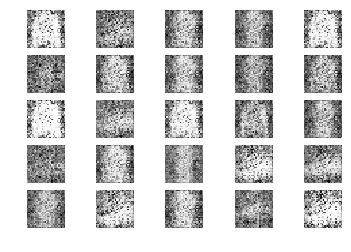

1401 [D loss: 0.599481, acc.: 67.19%] [G loss: 0.877181]
1402 [D loss: 0.756768, acc.: 45.31%] [G loss: 0.839873]
1403 [D loss: 0.669354, acc.: 48.44%] [G loss: 0.861309]
1404 [D loss: 0.700438, acc.: 50.00%] [G loss: 0.826627]
1405 [D loss: 0.712874, acc.: 50.00%] [G loss: 0.809170]
1406 [D loss: 0.671141, acc.: 54.69%] [G loss: 0.830613]
1407 [D loss: 0.656291, acc.: 59.38%] [G loss: 0.756354]
1408 [D loss: 0.694856, acc.: 51.56%] [G loss: 0.788315]
1409 [D loss: 0.652300, acc.: 59.38%] [G loss: 0.802700]
1410 [D loss: 0.746948, acc.: 48.44%] [G loss: 0.728893]
1411 [D loss: 0.689688, acc.: 59.38%] [G loss: 0.781168]
1412 [D loss: 0.673127, acc.: 56.25%] [G loss: 0.750545]
1413 [D loss: 0.640812, acc.: 60.94%] [G loss: 0.797382]
1414 [D loss: 0.653174, acc.: 62.50%] [G loss: 0.850103]
1415 [D loss: 0.625367, acc.: 67.19%] [G loss: 0.823655]
1416 [D loss: 0.716922, acc.: 46.88%] [G loss: 0.815545]
1417 [D loss: 0.649123, acc.: 73.44%] [G loss: 0.880411]
1418 [D loss: 0.692187, acc.: 5

1548 [D loss: 0.677736, acc.: 56.25%] [G loss: 0.836162]
1549 [D loss: 0.679820, acc.: 57.81%] [G loss: 0.846127]
1550 [D loss: 0.671119, acc.: 59.38%] [G loss: 0.830688]
1551 [D loss: 0.680532, acc.: 54.69%] [G loss: 0.860472]
1552 [D loss: 0.691835, acc.: 54.69%] [G loss: 0.779639]
1553 [D loss: 0.643525, acc.: 60.94%] [G loss: 0.803988]
1554 [D loss: 0.679321, acc.: 51.56%] [G loss: 0.811325]
1555 [D loss: 0.687251, acc.: 51.56%] [G loss: 0.817935]
1556 [D loss: 0.654548, acc.: 65.62%] [G loss: 0.923463]
1557 [D loss: 0.657863, acc.: 53.12%] [G loss: 0.787637]
1558 [D loss: 0.632843, acc.: 60.94%] [G loss: 0.769792]
1559 [D loss: 0.638385, acc.: 60.94%] [G loss: 0.790840]
1560 [D loss: 0.710153, acc.: 46.88%] [G loss: 0.762002]
1561 [D loss: 0.646673, acc.: 57.81%] [G loss: 0.747243]
1562 [D loss: 0.672816, acc.: 59.38%] [G loss: 0.790112]
1563 [D loss: 0.668605, acc.: 62.50%] [G loss: 0.768367]
1564 [D loss: 0.745248, acc.: 42.19%] [G loss: 0.848341]
1565 [D loss: 0.655094, acc.: 6

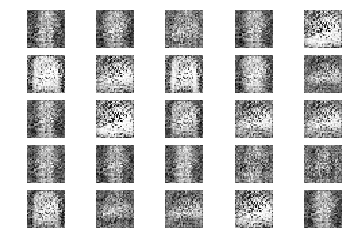

1601 [D loss: 0.702376, acc.: 46.88%] [G loss: 0.718525]
1602 [D loss: 0.719548, acc.: 34.38%] [G loss: 0.896278]
1603 [D loss: 0.687856, acc.: 42.19%] [G loss: 0.742464]
1604 [D loss: 0.636195, acc.: 59.38%] [G loss: 0.772658]
1605 [D loss: 0.683169, acc.: 53.12%] [G loss: 0.731060]
1606 [D loss: 0.674987, acc.: 46.88%] [G loss: 0.744323]
1607 [D loss: 0.697116, acc.: 37.50%] [G loss: 0.691196]
1608 [D loss: 0.706767, acc.: 43.75%] [G loss: 0.654370]
1609 [D loss: 0.681148, acc.: 50.00%] [G loss: 0.728384]
1610 [D loss: 0.667022, acc.: 51.56%] [G loss: 0.727953]
1611 [D loss: 0.694215, acc.: 50.00%] [G loss: 0.765141]
1612 [D loss: 0.704835, acc.: 39.06%] [G loss: 0.739085]
1613 [D loss: 0.682251, acc.: 56.25%] [G loss: 0.786422]
1614 [D loss: 0.666565, acc.: 53.12%] [G loss: 0.725302]
1615 [D loss: 0.653982, acc.: 53.12%] [G loss: 0.660593]
1616 [D loss: 0.671548, acc.: 64.06%] [G loss: 0.723275]
1617 [D loss: 0.692343, acc.: 54.69%] [G loss: 0.728112]
1618 [D loss: 0.665510, acc.: 5

1747 [D loss: 0.702693, acc.: 54.69%] [G loss: 0.858612]
1748 [D loss: 0.585149, acc.: 75.00%] [G loss: 0.960501]
1749 [D loss: 0.639531, acc.: 59.38%] [G loss: 0.897030]
1750 [D loss: 0.697091, acc.: 46.88%] [G loss: 0.765292]
1751 [D loss: 0.661086, acc.: 54.69%] [G loss: 0.722284]
1752 [D loss: 0.662147, acc.: 60.94%] [G loss: 0.732856]
1753 [D loss: 0.739719, acc.: 40.62%] [G loss: 0.787753]
1754 [D loss: 0.633822, acc.: 62.50%] [G loss: 0.898941]
1755 [D loss: 0.622971, acc.: 70.31%] [G loss: 0.931165]
1756 [D loss: 0.653298, acc.: 57.81%] [G loss: 0.913776]
1757 [D loss: 0.649190, acc.: 65.62%] [G loss: 0.846081]
1758 [D loss: 0.670159, acc.: 59.38%] [G loss: 0.716585]
1759 [D loss: 0.632050, acc.: 62.50%] [G loss: 0.750888]
1760 [D loss: 0.670773, acc.: 62.50%] [G loss: 0.831223]
1761 [D loss: 0.679916, acc.: 56.25%] [G loss: 0.886522]
1762 [D loss: 0.662281, acc.: 60.94%] [G loss: 0.838513]
1763 [D loss: 0.612608, acc.: 71.88%] [G loss: 0.872662]
1764 [D loss: 0.645276, acc.: 5

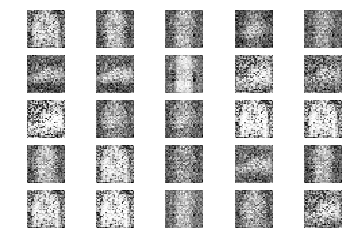

1801 [D loss: 0.649081, acc.: 59.38%] [G loss: 0.803510]
1802 [D loss: 0.572742, acc.: 84.38%] [G loss: 1.049636]
1803 [D loss: 0.410155, acc.: 87.50%] [G loss: 1.980415]
1804 [D loss: 0.412038, acc.: 89.06%] [G loss: 1.682693]
1805 [D loss: 0.633316, acc.: 70.31%] [G loss: 0.955195]
1806 [D loss: 0.666910, acc.: 51.56%] [G loss: 0.834020]
1807 [D loss: 0.527168, acc.: 87.50%] [G loss: 1.185897]
1808 [D loss: 0.515040, acc.: 85.94%] [G loss: 1.264508]
1809 [D loss: 0.489387, acc.: 87.50%] [G loss: 1.168541]
1810 [D loss: 0.539880, acc.: 87.50%] [G loss: 1.037057]
1811 [D loss: 0.585243, acc.: 71.88%] [G loss: 0.903637]
1812 [D loss: 0.529091, acc.: 81.25%] [G loss: 1.012359]
1813 [D loss: 0.516898, acc.: 79.69%] [G loss: 1.227758]
1814 [D loss: 0.432337, acc.: 82.81%] [G loss: 1.752445]
1815 [D loss: 0.403050, acc.: 81.25%] [G loss: 1.834299]
1816 [D loss: 0.636415, acc.: 64.06%] [G loss: 0.843245]
1817 [D loss: 0.573115, acc.: 76.56%] [G loss: 1.105662]
1818 [D loss: 0.412947, acc.: 8

1945 [D loss: 0.278231, acc.: 93.75%] [G loss: 3.966245]
1946 [D loss: 0.242954, acc.: 92.19%] [G loss: 3.671233]
1947 [D loss: 0.290474, acc.: 96.88%] [G loss: 1.930668]
1948 [D loss: 0.515552, acc.: 73.44%] [G loss: 2.603457]
1949 [D loss: 0.256136, acc.: 93.75%] [G loss: 5.755907]
1950 [D loss: 0.279727, acc.: 95.31%] [G loss: 3.438570]
1951 [D loss: 0.427674, acc.: 78.12%] [G loss: 2.070868]
1952 [D loss: 0.338367, acc.: 89.06%] [G loss: 2.494047]
1953 [D loss: 0.379427, acc.: 82.81%] [G loss: 3.746089]
1954 [D loss: 0.241752, acc.: 93.75%] [G loss: 4.740572]
1955 [D loss: 0.225607, acc.: 95.31%] [G loss: 3.677276]
1956 [D loss: 0.411758, acc.: 79.69%] [G loss: 2.562152]
1957 [D loss: 0.302882, acc.: 98.44%] [G loss: 3.087669]
1958 [D loss: 0.430414, acc.: 81.25%] [G loss: 3.486658]
1959 [D loss: 0.373588, acc.: 85.94%] [G loss: 3.069489]
1960 [D loss: 0.180004, acc.: 96.88%] [G loss: 3.734029]
1961 [D loss: 0.334064, acc.: 96.88%] [G loss: 2.742487]
1962 [D loss: 0.420033, acc.: 9

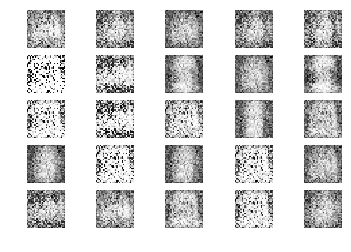

2001 [D loss: 0.327213, acc.: 84.38%] [G loss: 3.554618]
2002 [D loss: 0.347792, acc.: 84.38%] [G loss: 3.514267]
2003 [D loss: 0.267301, acc.: 96.88%] [G loss: 3.147840]
2004 [D loss: 0.315269, acc.: 87.50%] [G loss: 4.033381]
2005 [D loss: 0.297028, acc.: 89.06%] [G loss: 3.366422]
2006 [D loss: 0.436104, acc.: 79.69%] [G loss: 3.309048]
2007 [D loss: 0.410287, acc.: 79.69%] [G loss: 3.865901]
2008 [D loss: 0.362144, acc.: 85.94%] [G loss: 2.979782]
2009 [D loss: 0.226207, acc.: 98.44%] [G loss: 4.296651]
2010 [D loss: 0.220584, acc.: 96.88%] [G loss: 5.837226]
2011 [D loss: 0.372551, acc.: 82.81%] [G loss: 2.675503]
2012 [D loss: 0.290288, acc.: 90.62%] [G loss: 2.793386]
2013 [D loss: 0.268809, acc.: 90.62%] [G loss: 4.299286]
2014 [D loss: 0.234792, acc.: 92.19%] [G loss: 4.092008]
2015 [D loss: 0.479474, acc.: 81.25%] [G loss: 2.363525]
2016 [D loss: 0.313778, acc.: 93.75%] [G loss: 3.728740]
2017 [D loss: 0.389288, acc.: 81.25%] [G loss: 3.018942]
2018 [D loss: 0.317971, acc.: 9

2146 [D loss: 0.293149, acc.: 85.94%] [G loss: 4.773901]
2147 [D loss: 0.456556, acc.: 78.12%] [G loss: 2.229578]
2148 [D loss: 0.214996, acc.: 96.88%] [G loss: 3.595627]
2149 [D loss: 0.376888, acc.: 90.62%] [G loss: 3.490298]
2150 [D loss: 0.327097, acc.: 92.19%] [G loss: 3.802138]
2151 [D loss: 0.307917, acc.: 85.94%] [G loss: 4.425958]
2152 [D loss: 0.246325, acc.: 93.75%] [G loss: 3.068037]
2153 [D loss: 0.414011, acc.: 82.81%] [G loss: 2.685397]
2154 [D loss: 0.331883, acc.: 85.94%] [G loss: 3.210915]
2155 [D loss: 0.281450, acc.: 93.75%] [G loss: 4.146280]
2156 [D loss: 0.223433, acc.: 96.88%] [G loss: 3.619545]
2157 [D loss: 0.280236, acc.: 92.19%] [G loss: 2.827408]
2158 [D loss: 0.351108, acc.: 78.12%] [G loss: 2.769288]
2159 [D loss: 0.443551, acc.: 76.56%] [G loss: 2.469448]
2160 [D loss: 0.292699, acc.: 87.50%] [G loss: 3.846815]
2161 [D loss: 0.283228, acc.: 93.75%] [G loss: 2.859526]
2162 [D loss: 0.314858, acc.: 93.75%] [G loss: 2.981010]
2163 [D loss: 0.280873, acc.: 9

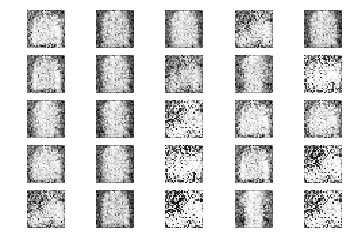

2201 [D loss: 0.436828, acc.: 79.69%] [G loss: 4.234530]
2202 [D loss: 0.151927, acc.: 96.88%] [G loss: 4.955674]
2203 [D loss: 0.356776, acc.: 89.06%] [G loss: 2.897153]
2204 [D loss: 0.231779, acc.: 87.50%] [G loss: 4.914990]
2205 [D loss: 0.375376, acc.: 81.25%] [G loss: 3.604009]
2206 [D loss: 0.228993, acc.: 89.06%] [G loss: 4.388767]
2207 [D loss: 0.451141, acc.: 70.31%] [G loss: 3.564780]
2208 [D loss: 0.166537, acc.: 96.88%] [G loss: 4.069146]
2209 [D loss: 0.514905, acc.: 73.44%] [G loss: 2.785669]
2210 [D loss: 0.268186, acc.: 92.19%] [G loss: 3.062866]
2211 [D loss: 0.181912, acc.: 96.88%] [G loss: 3.707115]
2212 [D loss: 0.532164, acc.: 67.19%] [G loss: 2.366575]
2213 [D loss: 0.394509, acc.: 85.94%] [G loss: 2.843082]
2214 [D loss: 0.354497, acc.: 82.81%] [G loss: 3.089715]
2215 [D loss: 0.302420, acc.: 87.50%] [G loss: 2.699670]
2216 [D loss: 0.381244, acc.: 84.38%] [G loss: 3.579582]
2217 [D loss: 0.305982, acc.: 84.38%] [G loss: 6.168969]
2218 [D loss: 0.323668, acc.: 8

2347 [D loss: 0.312615, acc.: 89.06%] [G loss: 3.250705]
2348 [D loss: 0.234036, acc.: 92.19%] [G loss: 4.684696]
2349 [D loss: 0.395653, acc.: 85.94%] [G loss: 3.806561]
2350 [D loss: 0.268363, acc.: 90.62%] [G loss: 3.833521]
2351 [D loss: 0.319064, acc.: 84.38%] [G loss: 3.512883]
2352 [D loss: 0.260056, acc.: 95.31%] [G loss: 2.732096]
2353 [D loss: 0.346314, acc.: 87.50%] [G loss: 3.650170]
2354 [D loss: 0.441790, acc.: 79.69%] [G loss: 3.713821]
2355 [D loss: 0.216324, acc.: 95.31%] [G loss: 4.722018]
2356 [D loss: 0.380764, acc.: 85.94%] [G loss: 3.793515]
2357 [D loss: 0.325102, acc.: 90.62%] [G loss: 4.910357]
2358 [D loss: 0.288363, acc.: 92.19%] [G loss: 4.793940]
2359 [D loss: 0.295963, acc.: 89.06%] [G loss: 4.601854]
2360 [D loss: 0.463220, acc.: 78.12%] [G loss: 4.799476]
2361 [D loss: 0.222597, acc.: 92.19%] [G loss: 6.091282]
2362 [D loss: 0.545408, acc.: 68.75%] [G loss: 2.278192]
2363 [D loss: 0.548909, acc.: 76.56%] [G loss: 2.572582]
2364 [D loss: 0.177395, acc.: 9

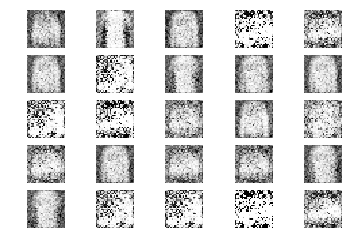

2401 [D loss: 0.500831, acc.: 73.44%] [G loss: 2.317997]
2402 [D loss: 0.450598, acc.: 81.25%] [G loss: 2.639949]
2403 [D loss: 0.455513, acc.: 75.00%] [G loss: 3.223608]
2404 [D loss: 0.206642, acc.: 95.31%] [G loss: 3.204618]
2405 [D loss: 0.431136, acc.: 75.00%] [G loss: 2.751818]
2406 [D loss: 0.380901, acc.: 87.50%] [G loss: 4.020459]
2407 [D loss: 0.247836, acc.: 95.31%] [G loss: 3.547511]
2408 [D loss: 0.213096, acc.: 93.75%] [G loss: 3.391302]
2409 [D loss: 0.264029, acc.: 90.62%] [G loss: 3.650856]
2410 [D loss: 0.266040, acc.: 93.75%] [G loss: 2.906600]
2411 [D loss: 0.339576, acc.: 87.50%] [G loss: 3.463933]
2412 [D loss: 0.328489, acc.: 84.38%] [G loss: 8.098698]
2413 [D loss: 0.537500, acc.: 67.19%] [G loss: 4.831595]
2414 [D loss: 0.198506, acc.: 96.88%] [G loss: 5.524533]
2415 [D loss: 0.306578, acc.: 89.06%] [G loss: 6.630320]
2416 [D loss: 0.322063, acc.: 89.06%] [G loss: 3.926059]
2417 [D loss: 0.320262, acc.: 79.69%] [G loss: 6.251349]
2418 [D loss: 0.327406, acc.: 9

2548 [D loss: 0.224189, acc.: 95.31%] [G loss: 3.958481]
2549 [D loss: 0.318901, acc.: 81.25%] [G loss: 5.330983]
2550 [D loss: 0.224281, acc.: 96.88%] [G loss: 3.833933]
2551 [D loss: 0.270020, acc.: 93.75%] [G loss: 2.617751]
2552 [D loss: 0.332617, acc.: 85.94%] [G loss: 3.924439]
2553 [D loss: 0.230574, acc.: 89.06%] [G loss: 4.408844]
2554 [D loss: 0.364516, acc.: 79.69%] [G loss: 4.038199]
2555 [D loss: 0.184450, acc.: 90.62%] [G loss: 7.724260]
2556 [D loss: 0.207386, acc.: 92.19%] [G loss: 7.162170]
2557 [D loss: 0.307003, acc.: 84.38%] [G loss: 3.832571]
2558 [D loss: 0.209224, acc.: 92.19%] [G loss: 4.488930]
2559 [D loss: 0.252914, acc.: 85.94%] [G loss: 6.105663]
2560 [D loss: 0.163416, acc.: 96.88%] [G loss: 3.468743]
2561 [D loss: 0.194865, acc.: 95.31%] [G loss: 4.839966]
2562 [D loss: 0.460935, acc.: 70.31%] [G loss: 3.031682]
2563 [D loss: 0.449154, acc.: 76.56%] [G loss: 3.366071]
2564 [D loss: 0.451071, acc.: 78.12%] [G loss: 4.147251]
2565 [D loss: 0.524166, acc.: 6

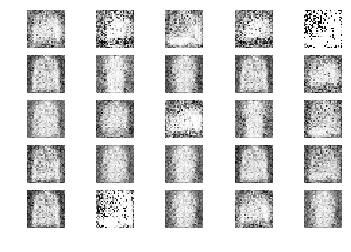

2601 [D loss: 0.175158, acc.: 92.19%] [G loss: 4.752975]
2602 [D loss: 0.369776, acc.: 78.12%] [G loss: 2.234746]
2603 [D loss: 0.186523, acc.: 95.31%] [G loss: 4.051434]
2604 [D loss: 0.279541, acc.: 87.50%] [G loss: 3.665955]
2605 [D loss: 0.431476, acc.: 79.69%] [G loss: 2.681912]
2606 [D loss: 0.311199, acc.: 93.75%] [G loss: 3.035453]
2607 [D loss: 0.306554, acc.: 87.50%] [G loss: 4.120198]
2608 [D loss: 0.242741, acc.: 90.62%] [G loss: 2.762508]
2609 [D loss: 0.399529, acc.: 75.00%] [G loss: 3.756606]
2610 [D loss: 0.372504, acc.: 76.56%] [G loss: 5.447078]
2611 [D loss: 0.487034, acc.: 73.44%] [G loss: 2.758613]
2612 [D loss: 0.262425, acc.: 92.19%] [G loss: 3.218852]
2613 [D loss: 0.358938, acc.: 89.06%] [G loss: 2.806690]
2614 [D loss: 0.302434, acc.: 92.19%] [G loss: 2.864031]
2615 [D loss: 0.307951, acc.: 90.62%] [G loss: 2.540888]
2616 [D loss: 0.277996, acc.: 98.44%] [G loss: 3.533523]
2617 [D loss: 0.368896, acc.: 84.38%] [G loss: 6.824039]
2618 [D loss: 0.403484, acc.: 7

2748 [D loss: 0.274699, acc.: 84.38%] [G loss: 2.981210]
2749 [D loss: 0.539627, acc.: 65.62%] [G loss: 2.978322]
2750 [D loss: 0.309164, acc.: 92.19%] [G loss: 4.983021]
2751 [D loss: 0.235324, acc.: 90.62%] [G loss: 4.914805]
2752 [D loss: 0.335584, acc.: 81.25%] [G loss: 2.917583]
2753 [D loss: 0.253234, acc.: 93.75%] [G loss: 4.887146]
2754 [D loss: 0.354448, acc.: 82.81%] [G loss: 2.540530]
2755 [D loss: 0.297685, acc.: 87.50%] [G loss: 3.452335]
2756 [D loss: 0.219223, acc.: 93.75%] [G loss: 2.984357]
2757 [D loss: 0.307473, acc.: 81.25%] [G loss: 3.332677]
2758 [D loss: 0.259330, acc.: 87.50%] [G loss: 4.088925]
2759 [D loss: 0.422690, acc.: 75.00%] [G loss: 3.403839]
2760 [D loss: 0.187523, acc.: 93.75%] [G loss: 4.682130]
2761 [D loss: 0.252716, acc.: 93.75%] [G loss: 2.035233]
2762 [D loss: 0.297829, acc.: 92.19%] [G loss: 3.500913]
2763 [D loss: 0.297734, acc.: 82.81%] [G loss: 5.351198]
2764 [D loss: 0.309638, acc.: 89.06%] [G loss: 5.177948]
2765 [D loss: 0.222354, acc.: 9

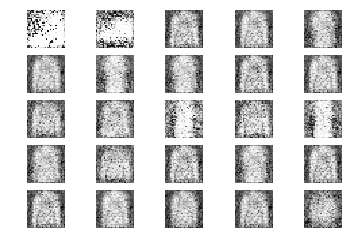

2801 [D loss: 0.289769, acc.: 85.94%] [G loss: 3.209840]
2802 [D loss: 0.409938, acc.: 81.25%] [G loss: 3.117721]
2803 [D loss: 0.415203, acc.: 71.88%] [G loss: 6.317390]
2804 [D loss: 0.361284, acc.: 84.38%] [G loss: 1.454784]
2805 [D loss: 0.340265, acc.: 87.50%] [G loss: 3.322905]
2806 [D loss: 0.400354, acc.: 84.38%] [G loss: 3.589718]
2807 [D loss: 0.376065, acc.: 81.25%] [G loss: 2.806594]
2808 [D loss: 0.396658, acc.: 87.50%] [G loss: 3.438666]
2809 [D loss: 0.207769, acc.: 89.06%] [G loss: 3.878793]
2810 [D loss: 0.586668, acc.: 68.75%] [G loss: 2.625832]
2811 [D loss: 0.173915, acc.: 92.19%] [G loss: 6.422922]
2812 [D loss: 0.584417, acc.: 60.94%] [G loss: 3.272465]
2813 [D loss: 0.508857, acc.: 76.56%] [G loss: 4.424638]
2814 [D loss: 0.334495, acc.: 84.38%] [G loss: 3.335026]
2815 [D loss: 0.096219, acc.: 100.00%] [G loss: 3.949313]
2816 [D loss: 0.401416, acc.: 84.38%] [G loss: 3.430232]
2817 [D loss: 0.208364, acc.: 93.75%] [G loss: 4.425774]
2818 [D loss: 0.398275, acc.: 

2948 [D loss: 0.391497, acc.: 76.56%] [G loss: 2.315788]
2949 [D loss: 0.232846, acc.: 95.31%] [G loss: 3.027456]
2950 [D loss: 0.494404, acc.: 70.31%] [G loss: 2.248837]
2951 [D loss: 0.316668, acc.: 89.06%] [G loss: 3.302732]
2952 [D loss: 0.623250, acc.: 70.31%] [G loss: 1.901588]
2953 [D loss: 0.481953, acc.: 73.44%] [G loss: 2.461544]
2954 [D loss: 0.275379, acc.: 92.19%] [G loss: 2.994239]
2955 [D loss: 0.485563, acc.: 73.44%] [G loss: 2.328842]
2956 [D loss: 0.310906, acc.: 84.38%] [G loss: 5.572353]
2957 [D loss: 0.379525, acc.: 79.69%] [G loss: 2.527656]
2958 [D loss: 0.231500, acc.: 89.06%] [G loss: 5.124848]
2959 [D loss: 0.464525, acc.: 76.56%] [G loss: 3.352837]
2960 [D loss: 0.170915, acc.: 95.31%] [G loss: 7.832232]
2961 [D loss: 0.195211, acc.: 92.19%] [G loss: 5.360691]
2962 [D loss: 0.551101, acc.: 60.94%] [G loss: 2.303649]
2963 [D loss: 0.338699, acc.: 87.50%] [G loss: 3.863648]
2964 [D loss: 0.343244, acc.: 90.62%] [G loss: 2.462018]
2965 [D loss: 0.318672, acc.: 7

In [6]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=3000, batch_size=32, sample_interval=200)
#     gan.train(epochs=1000, batch_size=32, sample_interval=200)